### Overview

Association Rule Mining (ARM) is a technique used in data mining to discover interesting relationships, correlations, and patterns among items in large datasets. It identifies strong rules discovered in databases using measures like support, confidence, and lift. These rules are used to highlight frequent item sets and association patterns between variables in transactional datasets.

- Support: This refers to the proportion of transactions in the dataset that contain a particular item set. It measures how frequently an item or item set appears in the dataset.

- Confidence: Confidence refers to the likelihood that an item appears in a transaction given that another item is already present. It is the conditional probability of the occurrence of the consequent given the antecedent.

- Lift: Lift evaluates how much more likely the consequent is to occur when the antecedent occurs than it would be expected by random chance. It is calculated as the ratio of the observed support to the expected support if the items were independent.

The Apriori Algorithm is a popular algorithm used to perform ARM. It works by identifying the frequent item sets in the dataset and then generating association rules from them. The algorithm uses a bottom-up approach, where frequent item sets are extended one item at a time (a step known as candidate generation) and groups of candidates are tested against the data.

### Data Preperation

Association Rule Mining (ARM) requires data to be in transactional form, where each row represents a transaction and each column represents the presence or absence of an "item" in that transaction. In the context of air quality data, each row corresponds to a pollution measurement event, and each pollutant level (e.g., pm25_Low, no2_High) is treated as an item.

In order to convert the dataset into a suitable format for ARM:

The pollutant concentrations were binned into categories (Low, Medium, High) using quantiles.
This was followed by one-hot encoding, creating a binary matrix where each column indicates whether a particular pollutant level was present (True/1) or absent (False/0) in each transaction.
Below is a sample of the binary transactional data used in the ARM analysis:

In [49]:
import pandas as pd
import numpy as np

# Load the cleaned dataset
df = pd.read_csv('final_cleaned.csv')

# Ensure the correct pollutant columns are used (adjust as necessary)
pollutants = ['pm25', 'pm10', 'no2', 'so2', 'o3', 'co']

# Binning the pollutant values into categorical bins (Low, Medium, High)
for pollutant in pollutants:
    df[pollutant] = pd.qcut(df['value'][df['pollutant'] == pollutant], q=3, labels=['Low', 'Medium', 'High'])

# Pivot the dataset to have pollutant categories in columns
df_pivot = df.pivot_table(values='value', index=['location', 'city', 'country', 'timestamp', 'latitude', 'longitude'],
                          columns='pollutant', aggfunc='first')

# Reset index to make 'location', 'city', 'country', etc. columns again
df_pivot.reset_index(inplace=True)

# Binning pollutant values
for pollutant in pollutants:
    if pollutant in df_pivot.columns:
        df_pivot[pollutant] = pd.qcut(df_pivot[pollutant], q=3, labels=['Low', 'Medium', 'High'])

# Apply One-Hot Encoding to create the binary matrix
df_encoded = pd.get_dummies(df_pivot[pollutants])

# Display a sample of the encoded dataset
print(df_encoded.head())

   pm25_Low  pm25_Medium  pm25_High  pm10_Low  pm10_Medium  pm10_High  \
0     False        False      False     False         True      False   
1     False        False      False     False        False       True   
2     False        False      False      True        False      False   
3     False        False      False      True        False      False   
4     False        False      False     False        False       True   

   no2_Low  no2_Medium  no2_High  so2_Low  so2_Medium  so2_High  o3_Low  \
0    False        True     False    False       False      True   False   
1    False       False      True    False       False      True   False   
2    False        True     False    False       False      True   False   
3    False        True     False    False       False      True   False   
4    False       False      True    False       False      True   False   

   o3_Medium  o3_High  co_Low  co_Medium  co_High  
0      False     True   False       True    False  
1     

In [51]:
# Save the prepared dataset to a CSV file (optional)
df_encoded.to_csv('prepared_pollutant_data_for_ARM.csv', index=False)

### Code: ARM with Apriori Algorithm

     support                    itemsets
0   0.145143                  (pm25_Low)
1   0.144529               (pm25_Medium)
2   0.144096                 (pm25_High)
3   0.122950                  (pm10_Low)
4   0.122950               (pm10_Medium)
..       ...                         ...
57  0.025815         (o3_High, so2_High)
58  0.022578         (co_High, so2_High)
59  0.025091            (o3_Low, co_Low)
60  0.020916        (co_High, o3_Medium)
61  0.020657  (o3_Low, so2_Low, no2_Low)

[62 rows x 2 columns]
           antecedents  consequents  antecedent support  consequent support  \
0           (pm10_Low)   (pm25_Low)            0.122950            0.145143   
1          (pm10_High)  (pm25_High)            0.122950            0.144096   
2          (pm25_High)  (pm10_High)            0.144096            0.122950   
3            (so2_Low)    (no2_Low)            0.075513            0.143313   
4             (co_Low)    (no2_Low)            0.053333            0.143313   
5         (

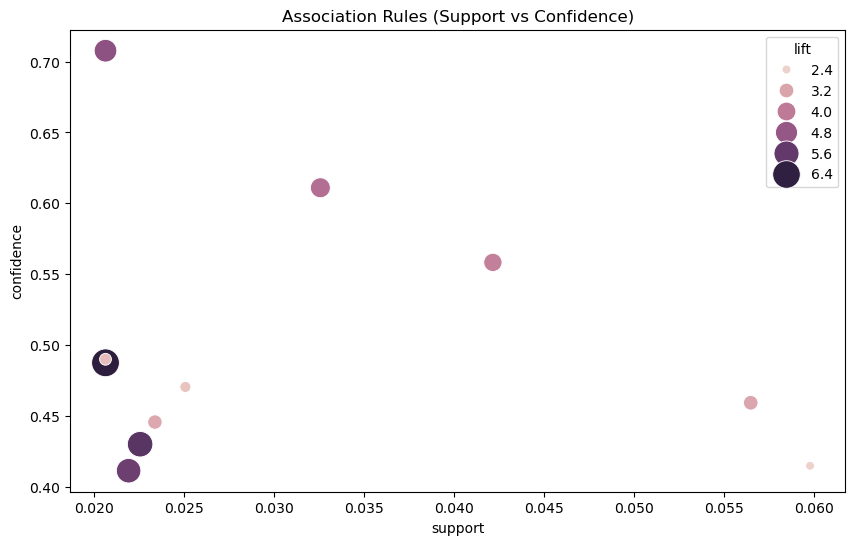

In [64]:
from mlxtend.frequent_patterns import apriori, association_rules

# Apply the Apriori algorithm to find frequent itemsets
# Set a lower minimum support threshold to capture more itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.018, use_colnames=True)

# Display the frequent itemsets
print(frequent_itemsets)

# Apply the association rule mining with a lower confidence threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.35)

# Display the rules generated
print(rules)

# Visualizing the rules (optional, you can also use a network plot or matrix plot)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(x='support', y='confidence', size='lift', data=filtered_rules, hue='lift', sizes=(40, 400))
plt.title('Association Rules (Support vs Confidence)')
plt.show()

Visualization of Association Rules:

To visualize the associations, a network diagram was generated to depict the relationships between pollutant levels. Each node represents a pollutant (at varying levels like low, medium, high), and the edges represent association rules. The thickness of the edges correlates to the support, while the color intensity correlates to the lift of the rule.

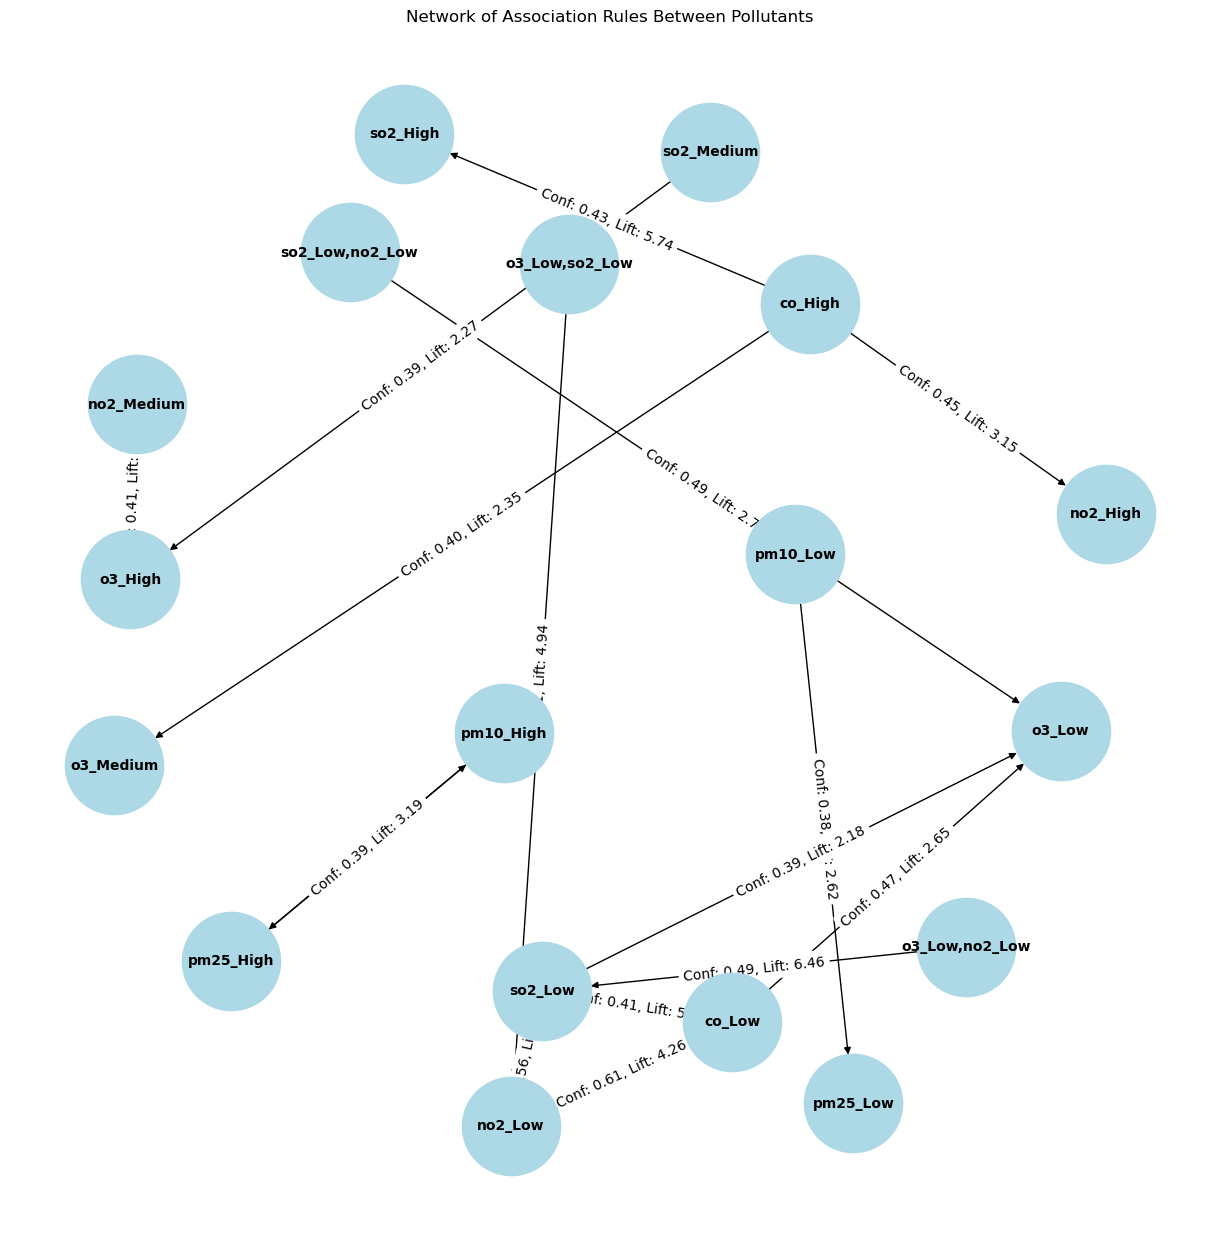

In [66]:
# Visualization: Network of Association Rules
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.DiGraph()

# Add nodes and edges for antecedents and consequents
for idx, row in rules.iterrows():
    G.add_edge(','.join(list(row['antecedents'])), ','.join(list(row['consequents'])),
               weight=row['support'], label=f"Conf: {row['confidence']:.2f}, Lift: {row['lift']:.2f}")

# Plot the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=5000, font_size=10, font_weight='bold')

# Draw edges
edges = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edges)

plt.title('Network of Association Rules Between Pollutants')
plt.show()

### Conclusions

Through the application of Association Rule Mining (ARM) using the Apriori algorithm, the following key conclusions were drawn that directly pertain to air quality analysis:

1. Pollutant Co-occurrence Patterns:

- Strong associations between certain pollutants such as SO2, NO2, and PM10 were identified. For example, the rule so2_Low → no2_Low indicates that when the concentration of SO2 is low, the concentration of NO2 is also likely to be low with a high confidence and lift value.
- Similar patterns were observed with PM10 and PM25 pollutants, suggesting that regions experiencing high levels of one particulate matter pollutant are likely to see a corresponding rise in another.

2. Intervention Insights:

- The rules and relationships identified provide actionable insights into pollution mitigation. For instance, interventions aimed at reducing SO2 emissions could also result in a reduction in NO2 levels, amplifying the effect of pollution control measures.
- This type of insight is useful for designing environmental policies that tackle multiple pollutants simultaneously, optimizing resource allocation for pollution control.

3. Confidence and Lift as Indicators of Strong Associations:

- The lift values of over 5 in some rules, such as so2_Low → no2_Low, highlight strong positive associations. This suggests that reducing one pollutant is likely to result in reductions in others, confirming that these pollutants are closely linked in origin and behavior.
- These results support the hypothesis that controlling industrial or vehicular emissions could reduce the concentration of multiple harmful pollutants, improving air quality.

4. Challenges in Data Interpretation:

- One challenge noted during the analysis was the presence of misclassified or redundant data, such as rows where pollutant levels did not align with typical patterns. Data preprocessing and cleaning were essential to ensure that the results from ARM were meaningful and applicable.

5. Data-Driven Decision Making:

- The results from this analysis can be used by urban planners and policymakers to focus their efforts on highly associated pollutants, leveraging the co-occurrence patterns to implement effective, multi-pollutant reduction strategies.
- This approach highlights the importance of data-driven decision making in tackling environmental challenges such as air pollution.

Next Steps:
- Further analysis could focus on exploring seasonal patterns or geographical differences to better understand how these associations evolve over time or in specific locations.
- Extending this model to include more pollutants or additional features such as temperature, humidity, and wind speed could refine the associations and make the models even more actionable.

In summary, Association Rule Mining has provided valuable insights into pollutant interactions, highlighting strong relationships that can inform pollution control strategies and contribute to the development of environmental policies that improve urban air quality.